# Bosch Copilot Survey Analysis


In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv(r"C:\Users\ayanp\responses.csv")
# Title case all column names
df.columns = [col.title() for col in df.columns]

In [45]:
# Create a copy of the original data for label encoding
data_label_encoded = df.copy()


# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('Productivity', axis=1)
y_label = data_label_encoded['Productivity']

### Technique 1 - Correlation Analysis

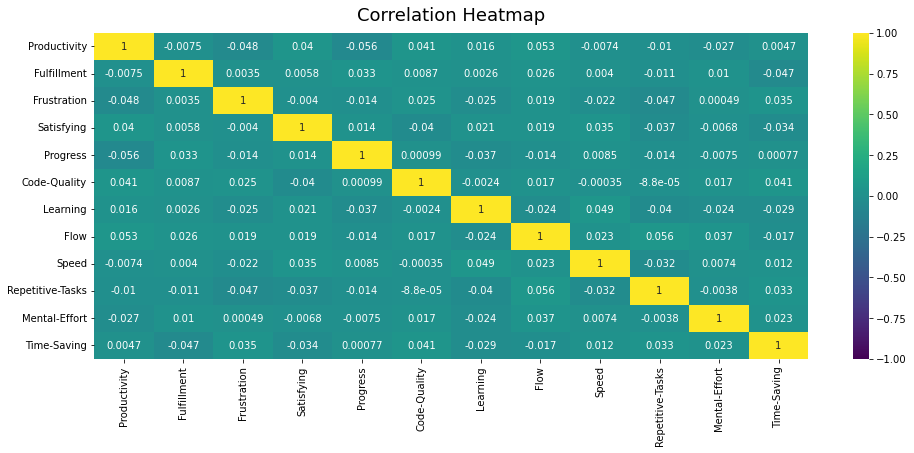

In [46]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='viridis')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [47]:
fi_df1  = df.corr(method='spearman')['Productivity'].iloc[1:].to_frame().reset_index().rename(columns={'index':'Feature','Productivity':'corr_coeff'})
fi_df1

Feature  corr_coeff
0        Fulfillment   -0.007503
1        Frustration   -0.048142
2         Satisfying    0.039744
3           Progress   -0.056196
4       Code-Quality    0.041264
5           Learning    0.016482
6               Flow    0.053186
7              Speed   -0.007388
8   Repetitive-Tasks   -0.010500
9      Mental-Effort   -0.026727
10       Time-Saving    0.004720

### Technique 2 -  Random Forest Feature Importance

In [48]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'Feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

Feature  rf_importance
8   Repetitive-Tasks       0.096386
5           Learning       0.094691
4       Code-Quality       0.094214
10       Time-Saving       0.093871
0        Fulfillment       0.092258
7              Speed       0.091543
2         Satisfying       0.089167
6               Flow       0.088951
1        Frustration       0.088665
9      Mental-Effort       0.086321
3           Progress       0.083933

### Technique 3 -  Gradient Boosting Feature importances

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'Feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

Feature  gb_importance
8   Repetitive-Tasks       0.138220
6               Flow       0.127525
2         Satisfying       0.097233
9      Mental-Effort       0.096269
10       Time-Saving       0.094960
4       Code-Quality       0.091402
5           Learning       0.089222
0        Fulfillment       0.084304
1        Frustration       0.074521
3           Progress       0.054625
7              Speed       0.051719

### Technique 4 - Permutation Importance

In [50]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'Feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

Feature  permutation_importance
6               Flow                0.015073
8   Repetitive-Tasks                0.011895
9      Mental-Effort                0.008424
1        Frustration                0.008299
0        Fulfillment                0.005593
2         Satisfying                0.005277
7              Speed                0.003181
10       Time-Saving               -0.000592
3           Progress               -0.006304
5           Learning               -0.009891
4       Code-Quality               -0.011008

### Technique 5 - RFE

In [51]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df5 = pd.DataFrame({
    'Feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df5

Feature  rfe_score
8   Repetitive-Tasks   0.094559
4       Code-Quality   0.094170
7              Speed   0.094170
5           Learning   0.092055
2         Satisfying   0.091917
9      Mental-Effort   0.090797
6               Flow   0.090760
0        Fulfillment   0.090660
10       Time-Saving   0.087763
3           Progress   0.087113
1        Frustration   0.086036

### Technique 6 - Logistic Ordinal Regression Weights

In [52]:
from mord import LogisticAT

# Fit the model
ordinal_model = LogisticAT()
ordinal_model.fit(X_label, y_label)

# Extract coefficients
fi_df6 = pd.DataFrame({
    'Feature': X_label.columns,
    'reg_coeffs': ordinal_model.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df6


Feature  reg_coeffs
6               Flow    0.068719
4       Code-Quality    0.054052
2         Satisfying    0.051625
5           Learning    0.016957
10       Time-Saving    0.010394
0        Fulfillment   -0.007592
7              Speed   -0.014764
8   Repetitive-Tasks   -0.019482
9      Mental-Effort   -0.033640
1        Frustration   -0.066313
3           Progress   -0.072893

### Technique 7 - SHAP

In [53]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_label, y_label)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_label)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

fi_df7 = pd.DataFrame({
    'Feature': X_label.columns,
    'SHAP_score': shap_sum
}).sort_values(by='SHAP_score', ascending=False)

fi_df7

Feature  SHAP_score
1        Frustration    0.104718
9      Mental-Effort    0.100437
6               Flow    0.099481
3           Progress    0.095752
2         Satisfying    0.093381
8   Repetitive-Tasks    0.082075
7              Speed    0.079327
10       Time-Saving    0.077476
5           Learning    0.074766
0        Fulfillment    0.070238
4       Code-Quality    0.068712

In [54]:
final_fi_df = fi_df1.merge(fi_df2,on='Feature').merge(fi_df3,on='Feature').merge(fi_df4,on='Feature').merge(fi_df5,on='Feature').merge(fi_df6,on='Feature').merge(fi_df7,on='Feature').set_index('Feature')
final_fi_df

corr_coeff  rf_importance  gb_importance  \
Feature                                                      
Fulfillment        -0.007503       0.092258       0.084304   
Frustration        -0.048142       0.088665       0.074521   
Satisfying          0.039744       0.089167       0.097233   
Progress           -0.056196       0.083933       0.054625   
Code-Quality        0.041264       0.094214       0.091402   
Learning            0.016482       0.094691       0.089222   
Flow                0.053186       0.088951       0.127525   
Speed              -0.007388       0.091543       0.051719   
Repetitive-Tasks   -0.010500       0.096386       0.138220   
Mental-Effort      -0.026727       0.086321       0.096269   
Time-Saving         0.004720       0.093871       0.094960   

                  permutation_importance  rfe_score  reg_coeffs  SHAP_score  
Feature                                                                      
Fulfillment                     0.005593   0.090660   -0.007592    0.070238  
Frustration                     0.008299   0.086036   -0.066313    0.104718  
Satisfying                      0.005277   0.091917    0.051625    0.093381  
Progress                       -0.006304   0.087113   -0.072893    0.095752  
Code-Quality                   -0.011008   0.094170    0.054052    0.068712  
Learning                       -0.009891   0.092055    0.016957    0.074766  
Flow                            0.015073   0.090760    0.068719    0.099481  
Speed                           0.003181   0.094170   -0.014764    0.079327  
Repetitive-Tasks                0.011895   0.094559   -0.019482    0.082075  
Mental-Effort                   0.008424   0.090797   -0.033640    0.100437  
Time-Saving                    -0.000592   0.087763    0.010394    0.077476

In [55]:
mean_importance = final_fi_df[['corr_coeff','rf_importance','gb_importance','permutation_importance','rfe_score','reg_coeffs','SHAP_score']].mean(axis=1).sort_values(ascending=False)
mean_importance

Feature
Flow                0.077671
Satisfying          0.066906
Code-Quality        0.061829
Repetitive-Tasks    0.056165
Learning            0.053469
Time-Saving         0.052656
Fulfillment         0.046851
Mental-Effort       0.045983
Speed               0.042541
Frustration         0.035398
Progress            0.026576
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


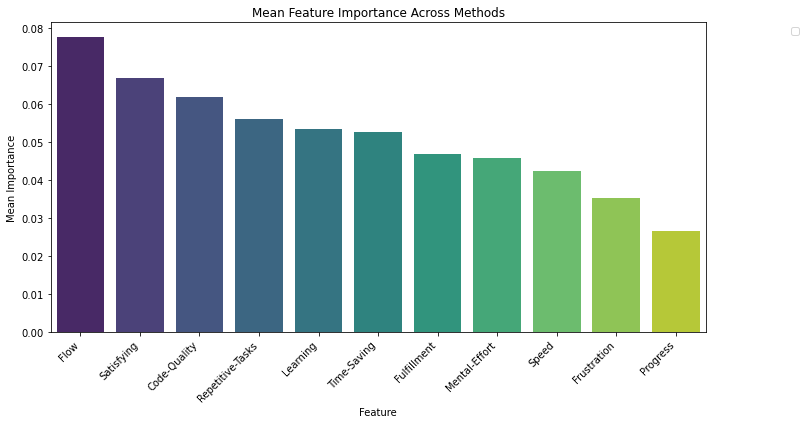

In [56]:
# Create a bar plot with custom color
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_importance.index, y=mean_importance.values, hue=mean_importance.index, palette='viridis', dodge=False)
plt.title('Mean Feature Importance Across Methods')
plt.xlabel('Feature')
plt.ylabel('Mean Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()